# Prerequisites



## Imports

In [1]:
#Importing all the necessary libraries
import os
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
import seaborn as sns
import re
import tensorflow as tf

#Libraries for tokenisation
!pip install nltk -U
!pip install spacy -U
!pip install simpletransformers
!pip install textattack
import nltk
from nltk import ngrams
import re
import spacy
from nltk.tokenize import word_tokenize
!python3 -m spacy download en_core_web_sm
sp = spacy.load('en_core_web_sm')

import nltk
from random import randint, choice
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

from collections import Counter
import string


from textattack.augmentation import WordNetAugmenter
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from simpletransformers.classification import ClassificationModel, ClassificationArgs


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## GPU

In [2]:
cuda_available = torch.cuda.is_available()
print('Cuda available? ',cuda_available)

if cuda_available:
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Cuda available?  True
Found GPU at: /device:GPU:0


## Data Extraction

In [3]:

!wget https://www.dropbox.com/s/ua3hw5hngibj8qu/dontpatronizeme_v1.4.zip
!unzip dontpatronizeme_v1.4.zip

!wget https://github.com/Perez-AlmendrosC/dontpatronizeme/archive/refs/heads/master.zip
!unzip master.zip

!mv dontpatronizeme-master/semeval-2022 ./semeval2022
!rm -rf dontpatronizeme-master

--2024-03-05 00:24:23--  https://www.dropbox.com/s/ua3hw5hngibj8qu/dontpatronizeme_v1.4.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ua3hw5hngibj8qu/dontpatronizeme_v1.4.zip [following]
--2024-03-05 00:24:23--  https://www.dropbox.com/s/raw/ua3hw5hngibj8qu/dontpatronizeme_v1.4.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc34437e27907e41b5b4468d5c78.dl.dropboxusercontent.com/cd/0/inline/COdqyG5a-hGzcdHOmdqlgKwK-EEEZ1igdXAS5bobaGkTghV8n6JCGliLwe88JRZZ4yjLZ-G-y6O2ohGVByq7yvmaoUkW3R7ams5oC8QGj-NmVPaPQgKdW96Zci4sHzS3otcVp80GjEtdpH71QDBcBaZM/file# [following]
--2024-03-05 00:24:23--  https://uc34437e27907e41b5b4468d5c78.dl.dropboxusercontent.com/cd/0/inline/COdqyG5a-hGzcdHOmdqlgKwK-EEEZ1igdXAS5bobaGkTghV8n6JCGliLwe88JRZZ4y

In [4]:
class DontPatronizeMe:

	def __init__(self, train_path, test_path):

		self.train_path = train_path
		self.test_path = test_path
		self.train_task1_df = None
		self.train_task2_df = None
		self.test_set_df = None

	def load_task1(self):
		"""
		Load task 1 training set and convert the tags into binary labels.
		Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
		Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.
		It returns a pandas dataframe with paragraphs and labels.
		"""
		rows=[]
		with open(os.path.join(self.train_path, 'dontpatronizeme_pcl.tsv'),
		          encoding='utf-8') as f:
			for line in f.readlines()[4:]:
				par_id=line.strip().split('\t')[0]
				art_id = line.strip().split('\t')[1]
				keyword=line.strip().split('\t')[2]
				country=line.strip().split('\t')[3]
				t=line.strip().split('\t')[4]#.lower()
				l=line.strip().split('\t')[-1]

				if l == '0' or l == '1':
					lbin = 0
				else:
					lbin = 1

				rows.append(
					{'par_id': par_id,
					'art_id': art_id,
					'keyword': keyword,
					'country': country,
					'text': t,
					'label': lbin,
					'orig_label': l
					}
					)
		df=pd.DataFrame(rows, columns=['par_id', 'art_id', 'keyword', 'country', 'text', 'label', 'orig_label'])
		self.train_task1_df = df

	def load_task2(self, return_one_hot=True):
		# Reads the data for task 2 and present it as paragraphs with binarized labels (a list with seven positions, "activated or not (1 or 0)",
		# depending on wether the category is present in the paragraph).
		# It returns a pandas dataframe with paragraphs and list of binarized labels.
		tag2id = {
				'Unbalanced_power_relations':0,
				'Shallow_solution':1,
				'Presupposition':2,
				'Authority_voice':3,
				'Metaphors':4,
				'Compassion':5,
				'The_poorer_the_merrier':6
				}
		print('Map of label to numerical label:')
		print(tag2id)
		data = defaultdict(list)
		with open (os.path.join(self.train_path, 'dontpatronizeme_categories.tsv'),
		           encoding='utf-8') as f:
			for line in f.readlines()[4:]:
				par_id=line.strip().split('\t')[0]
				art_id = line.strip().split('\t')[1]
				text=line.split('\t')[2]#.lower()
				keyword=line.split('\t')[3]
				country=line.split('\t')[4]
				start=line.split('\t')[5]
				finish=line.split('\t')[6]
				text_span=line.split('\t')[7]
				label=line.strip().split('\t')[-2]
				num_annotators=line.strip().split('\t')[-1]
				labelid = tag2id[label]

				if not labelid in data[(par_id, art_id, text, keyword, country)]:
					data[(par_id,art_id, text, keyword, country)].append(labelid)

		par_ids=[]
		art_ids=[]
		pars=[]
		keywords=[]
		countries=[]
		labels=[]

		for par_id, art_id, par, kw, co in data.keys():
			par_ids.append(par_id)
			art_ids.append(art_id)
			pars.append(par)
			keywords.append(kw)
			countries.append(co)

		for label in data.values():
			labels.append(label)

		if return_one_hot:
			labels = MultiLabelBinarizer().fit_transform(labels)
		df = pd.DataFrame(list(zip(par_ids,
									art_ids,
									pars,
									keywords,
									countries,
									labels)), columns=['par_id',
														'art_id',
														'text',
														'keyword',
														'country',
														'label',
														])
		self.train_task2_df = df


	def load_test(self):
		#self.test_df = [line.strip() for line in open(self.test_path)]
		rows=[]
		with open(self.test_path, encoding='utf-8') as f:
			for line in f:
				t=line.strip().split('\t')
				rows.append(t)
		self.test_set_df = pd.DataFrame(rows, columns="par_id art_id keyword country text".split())

In [5]:
dpm = DontPatronizeMe('./dontpatronizeme_v1.4/', './semeval2022/TEST/task4_test.tsv')
dpm.load_task1()

In [6]:
train_ids = pd.read_csv('semeval2022/practice splits/train_semeval_parids-labels.csv')
dev_ids = pd.read_csv('semeval2022/practice splits/dev_semeval_parids-labels.csv')

In [7]:
train_ids.par_id = train_ids.par_id.astype(str)
dev_ids.par_id = dev_ids.par_id.astype(str)

In [8]:
data = dpm.train_task1_df

## Load test data

In [183]:
dpm.load_test()
test_set = dpm.test_set_df



## Extract train - test data


In [131]:
def split_data_train_dev(data, split_ids):
  df = pd.DataFrame([
    {
        'par_id': par_id,
        'community': data.loc[data['par_id'] == par_id, 'keyword'].values[0],
        'text': data.loc[data['par_id'] == par_id, 'text'].values[0],
        'label': data.loc[data['par_id'] == par_id, 'label'].values[0],
        'score': data.loc[data['par_id'] == par_id, 'orig_label'].values[0],
        'category': data.loc[data['par_id'] == par_id, 'keyword'].values[0]
    }
    for par_id in split_ids.par_id
  ])

  return df

In [132]:
train_set = split_data_train_dev(data, train_ids)
dev_set = split_data_train_dev(data, dev_ids)

In [11]:
def rebalance_dataset(data):
  pcl_present = data.loc[data['label'] == 1]

  balanced_data = pd.concat([pcl_present, data.loc[data['label'] == 0]])[0:2*pcl_present.shape[0]]

  print(pcl_present.shape[0], balanced_data.shape[0])

  return balanced_data

In [192]:
print(len(train_set[train_set['label'] == 1]), len(train_set[train_set['label'] == 0 ]))
print(len(dev_set[dev_set['label'] == 1]), len(dev_set[dev_set['label'] == 0 ]))

794 7581
199 1895


#Data Analysis

##Understanding basic information about our data

In [13]:
# previewing top 5 rows
data.head()

par_id      art_id    keyword country  \
0      1  @@24942188   hopeless      ph   
1      2  @@21968160    migrant      gh   
2      3  @@16584954  immigrant      ie   
3      4   @@7811231   disabled      nz   
4      5   @@1494111    refugee      ca   

                                                text  label orig_label  
0  We 're living in times of absolute insanity , ...      0          0  
1  In Libya today , there are countless number of...      0          0  
2  "White House press secretary Sean Spicer said ...      0          0  
3  Council customers only signs would be displaye...      0          0  
4  """ Just like we received migrants fleeing El ...      0          0

In [14]:
#Understanding the basic information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10469 entries, 0 to 10468
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   par_id      10469 non-null  object
 1   art_id      10469 non-null  object
 2   keyword     10469 non-null  object
 3   country     10469 non-null  object
 4   text        10469 non-null  object
 5   label       10469 non-null  int64 
 6   orig_label  10469 non-null  object
dtypes: int64(1), object(6)
memory usage: 572.6+ KB


In [15]:
#getting the shape of the dataframe
data.shape #we have 7 features
print(f"There are {data.shape[0]} samples and {data.shape[1]} features in the dataset")

There are 10469 samples and 7 features in the dataset


In [16]:
#Getting the full list of the 7 columns in our dataset
data.columns
print(f"The full list of collumns in our dataset is: {data.columns}")

The full list of collumns in our dataset is: Index(['par_id', 'art_id', 'keyword', 'country', 'text', 'label',
       'orig_label'],
      dtype='object')


##Understanding our data more in depth

In [17]:
#Getting a statistical overview of all numerical attributes in the dataframe
data.describe()

label
count  10469.000000
mean       0.094851
std        0.293024
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000

In [18]:
#Checking for any missing values
data.isnull().sum() #there are no missing values

par_id        0
art_id        0
keyword       0
country       0
text          0
label         0
orig_label    0
dtype: int64

In [19]:
#unique labels from the orig_label column
data.orig_label.unique()

array(['0', '1', '2', '3', '4'], dtype=object)

In [20]:
#unique labels from the label column
data.label.unique()

array([0, 1])

In [21]:
#Seeing the frequency for each class label
data.label.value_counts()

0    9476
1     993
Name: label, dtype: int64

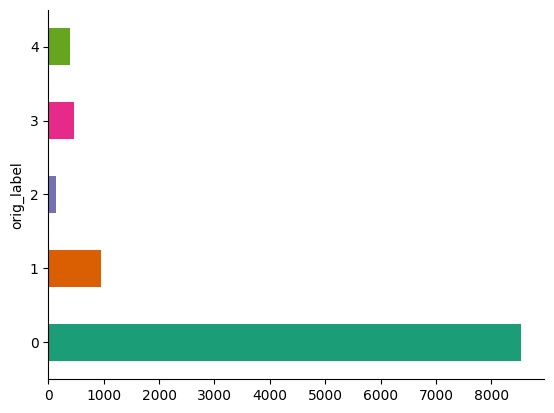

In [22]:
#Observing the freqeuncy for each label(0 to 5 - level of PCL detected) in the original labels
data.groupby('orig_label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-184-bcac60bdd837>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


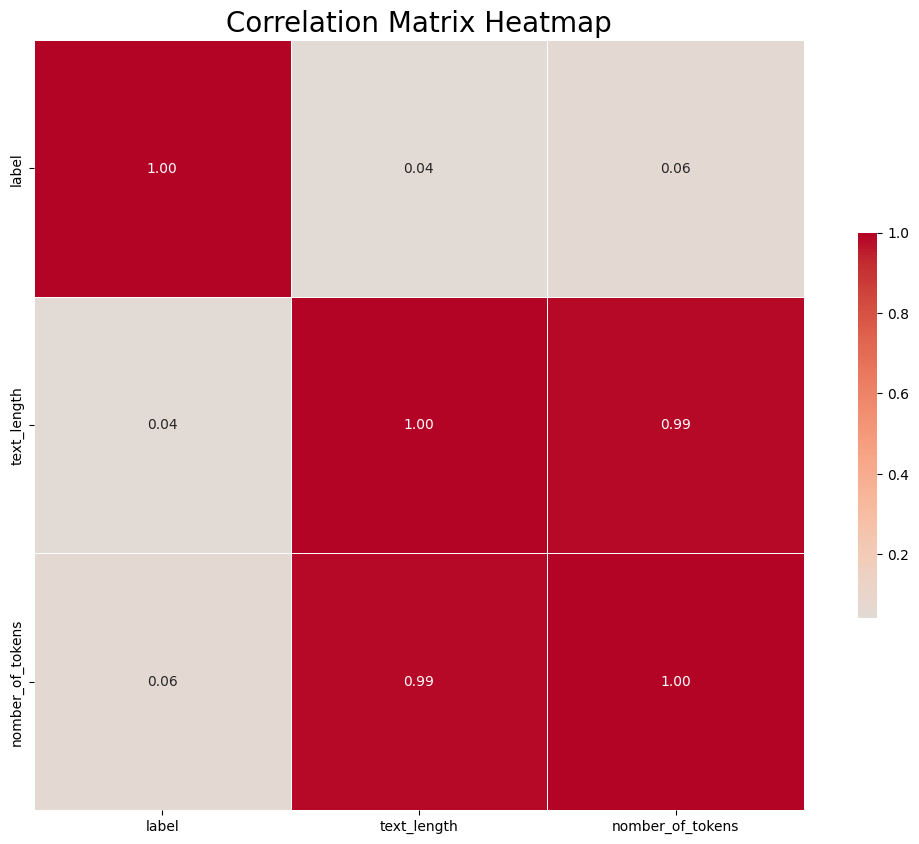

In [184]:
#Plotting the correlation matrix between our dataset's features
corr = data.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix Heatmap', fontsize=20)

plt.show()

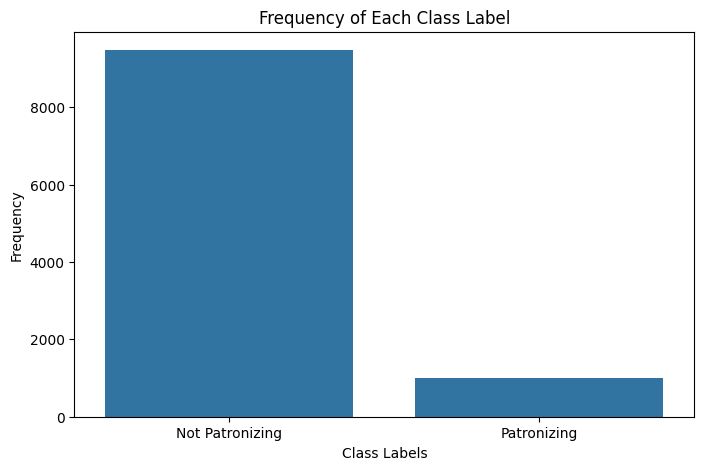

In [24]:
#the frequency of each class label
plt.figure(figsize=(8, 5))
sns.barplot(x=data['label'].value_counts().index, y=data['label'].value_counts().values)
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Each Class Label')
plt.xticks(ticks=[0, 1], labels=['Not Patronizing', 'Patronizing'])
plt.show()

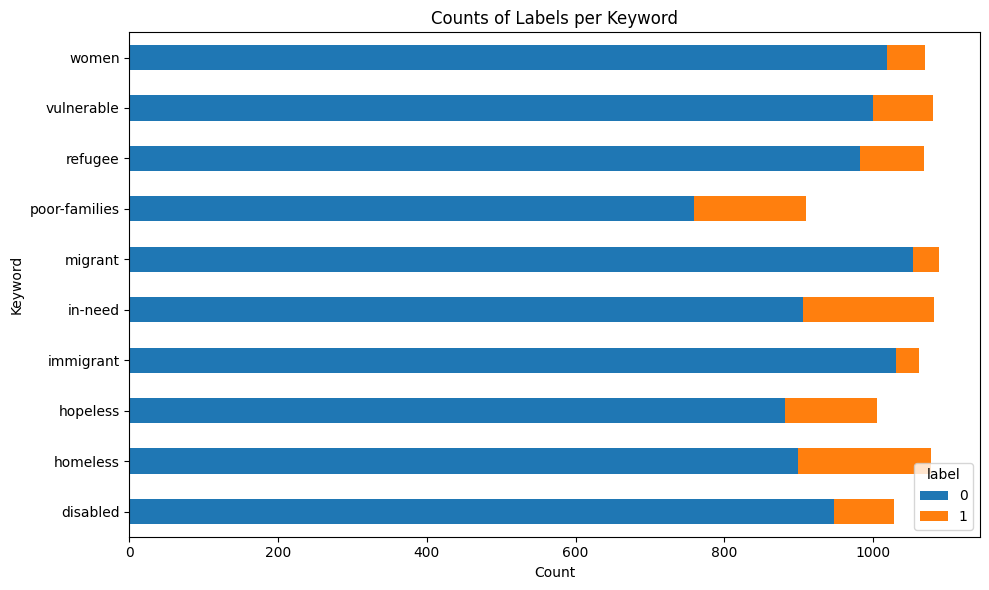

In [25]:
#Getting the counts of lables per keyword
grouped = data.groupby(['keyword', 'label']).size().reset_index(name='counts')
pivot_df = grouped.pivot(index='keyword', columns='label', values='counts')

pivot_df.plot(kind='barh', stacked=True, figsize=(10, 6))
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Counts of Labels per Keyword')
plt.tight_layout()
plt.show()

Gaining an insight into the text length:

In [26]:
# We create a new feature which depicts the length of the text
data['text_length'] = data['text'].apply(len)

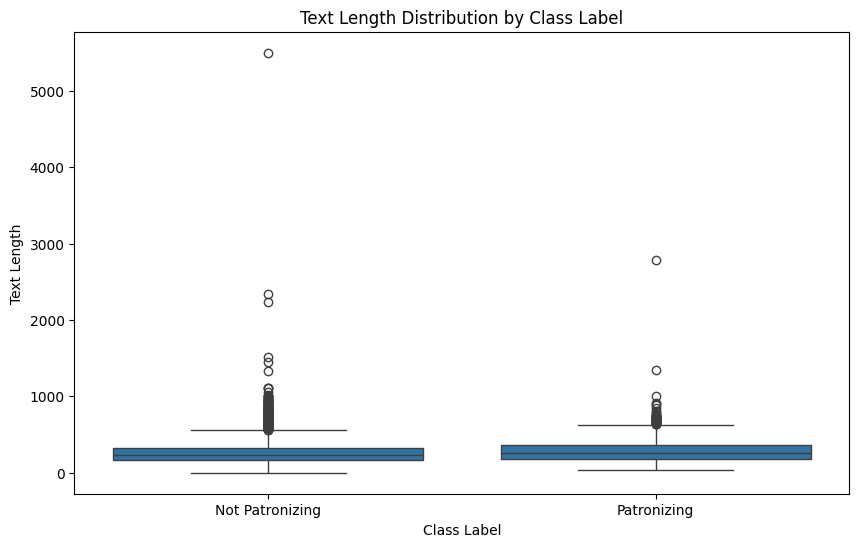

In [27]:
# Visualizing how text length varies across different class labels

plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=data)
plt.xlabel('Class Label')
plt.ylabel('Text Length')
plt.title('Text Length Distribution by Class Label')
plt.xticks(ticks=[0, 1], labels=['Not Patronizing', 'Patronizing'])
plt.show()

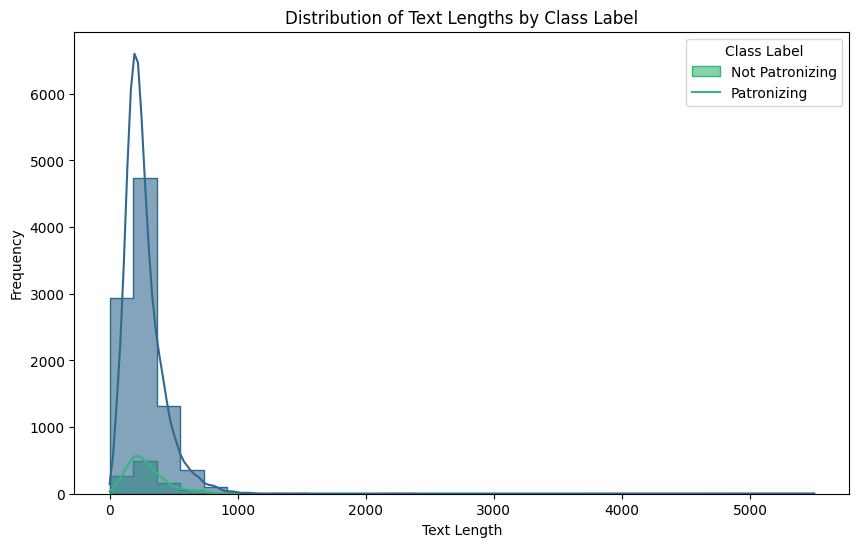

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='text_length', hue='label', bins=30, kde=True, palette='viridis', alpha=0.6, element='step')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths by Class Label')
plt.legend(title='Class Label', labels=['Not Patronizing', 'Patronizing'])
plt.show()

Gaining an insight into the number of tokens in a paragraph:

In [29]:
#We create a new feature which depicts the number of tokens
data["nomber_of_tokens"] = data['text'].apply(lambda x: len(x.split()))

In [30]:
#We check for empty text entries
empty_count = (data['text'].str.len() == 0).sum()
non_empty_count = (data['text'].str.len() > 0).sum()

print(f"Empty text entries: {empty_count}")
print(f"Non-empty text entries: {non_empty_count}")

Empty text entries: 1
Non-empty text entries: 10468


In [31]:
# Exploring the short sentences
for i in range(1,5):
    filtered_data = data[data['text'].apply(lambda x: len(x.split()) == i)]
    print(filtered_data)

     par_id      art_id  keyword country      text  label orig_label  \
1656   1657  @@10169794  refugee      gh  refugees      0          0   

      text_length  nomber_of_tokens  
1656            8                 1  
     par_id     art_id   keyword country              text  label orig_label  \
9063   9064  @@3318996  hopeless      za  Feeling hopeless      0          1   

      text_length  nomber_of_tokens  
9063           16                 2  
     par_id      art_id    keyword country                      text  label  \
317     318  @@15838984  immigrant      ph    The Filipino immigrant      0   
1954   1955   @@9390964    refugee      gh        Review refugee law      0   
3120   3121  @@14548958      women      jm  *Fighting over men/women      0   
6020   6021   @@2106876   hopeless      lk      Pretty much hopeless      0   

     orig_label  text_length  nomber_of_tokens  
317           0           22                 3  
1954          0           18                 3  

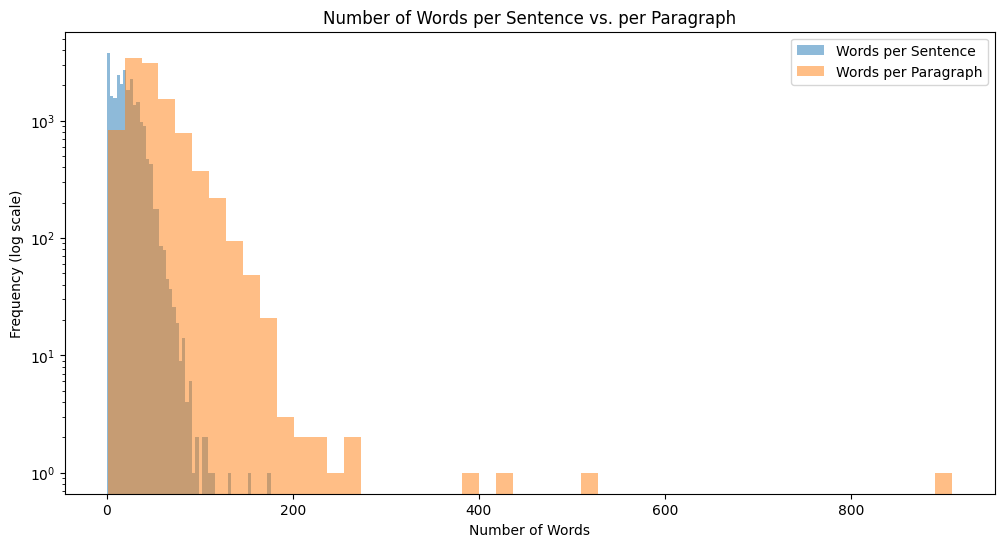

In [32]:
def count_words_sentences(text):
    sentences = [sentence.strip() for sentence in re.split(r'[.?!]', text) if sentence]
    return [len(sentence.split()) for sentence in sentences]


def count_words_paragraphs(text):
    paragraphs = [paragraph.strip() for paragraph in text.split('\n\n') if paragraph]
    return [len(paragraph.split()) for paragraph in paragraphs]

sentence_word_counts = sum(data['text'].apply(count_words_sentences).tolist(), [])
paragraph_word_counts = sum(data['text'].apply(count_words_paragraphs).tolist(), [])

plt.figure(figsize=(12, 6))
plt.hist(sentence_word_counts, bins=50, alpha=0.5, label='Words per Sentence', log=True)
plt.hist(paragraph_word_counts, bins=50, alpha=0.5, label='Words per Paragraph', log=True)
plt.xlabel('Number of Words')
plt.ylabel('Frequency (log scale)')
plt.title('Number of Words per Sentence vs. per Paragraph')
plt.legend()
plt.show()

In [33]:
#Inspecting the max and mean tokens per sentence
token_counts = data['text'].str.split().apply(len)

# Max number of tokens per sentence
max_tokens = token_counts.max()
print(f"Maximum number of tokens per sentence is {max_tokens}")

# Mean number of tokens per sentence
mean_tokens = token_counts.mean()
print(f"Mean number of tokens per sentence is {mean_tokens}")

token_counts_unique = data['text'].str.split().apply(len).unique()

# Max number of tokens per sentence
max_tokens_unique = token_counts_unique.max()
print(f"Maximum number of unique tokens per sentence is {max_tokens_unique}")

# Mean number of tokens per sentence
mean_tokens_unique = token_counts_unique.mean()
print(f"Mean number of unique tokens per sentence is {mean_tokens_unique}")

Maximum number of tokens per sentence is 909
Mean number of tokens per sentence is 48.42248543318369
Maximum number of unique tokens per sentence is 909
Mean number of unique tokens per sentence is 103.83957219251337


#Tokenisation and Token Analysis

In [34]:
#First, we create the corpus of words
corpus = data['text'].str.split().explode().tolist()

In [35]:
#Removing the stop word from our corpus

#Getting the set of stopwords
stop_words = set(stopwords.words('english'))
print(len(stop_words))
#Filtering out our corpus
filtered_corpus = [token for token in corpus if token not in stop_words]

179


In [36]:
print(f"Length of our corpus without any stop words is: {len(filtered_corpus)}")

Length of our corpus without any stop words is: 328492


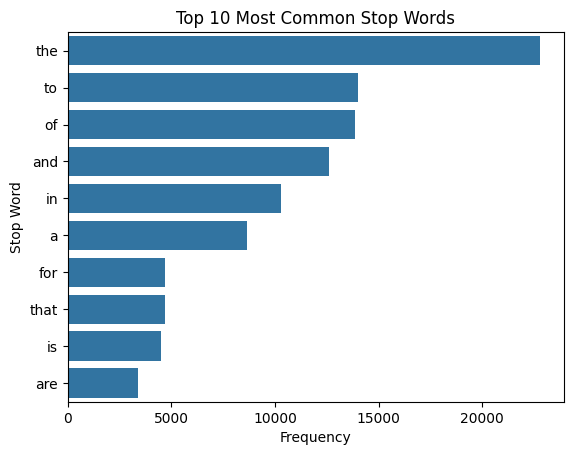

In [37]:
#Making a bar plot with the 10 most common stop words
corpus_dataframe = pd.DataFrame(corpus, columns=['word'])

stop_words_dataframe= corpus_dataframe[corpus_dataframe['word'].isin(stop_words)]

top_stop_words = stop_words_dataframe['word'].value_counts().head(10)
top_stop_words = top_stop_words.reset_index().rename(columns={'index': 'word', 'word': 'count'})

sns.barplot(x='count', y='word', data=top_stop_words)
plt.xlabel('Frequency')
plt.ylabel('Stop Word')
plt.title('Top 10 Most Common Stop Words')
plt.show()

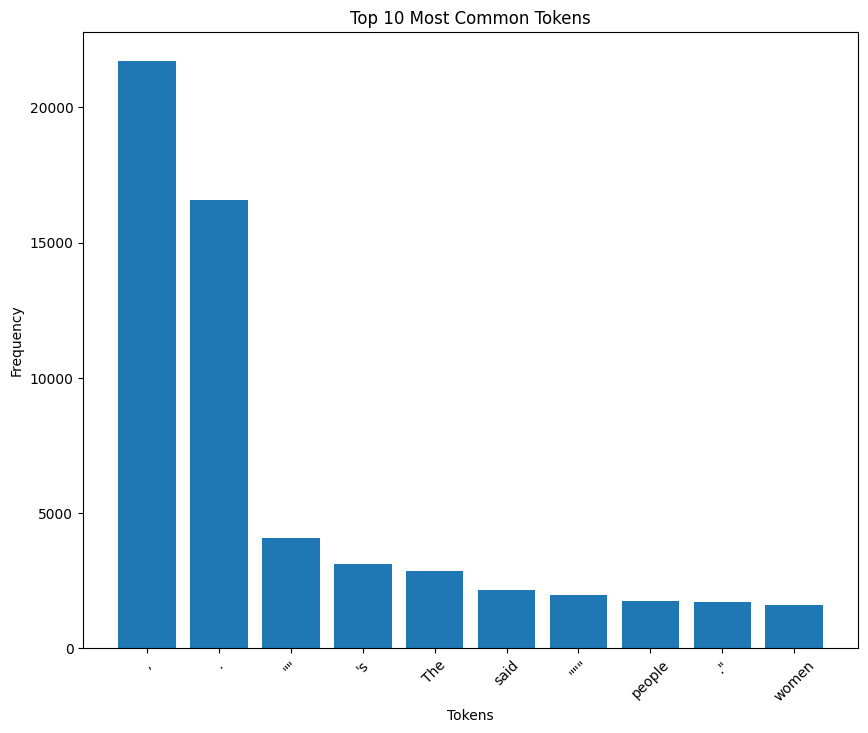

In [38]:
#Making a barplot of the 10 most common tokens
token_counts = Counter(filtered_corpus)
most_common_tokens = token_counts.most_common(10)

tokens, counts = zip(*most_common_tokens)

plt.figure(figsize=(10, 8))
plt.bar(tokens, counts)
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Tokens')
plt.xticks(rotation=45)
plt.show()

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


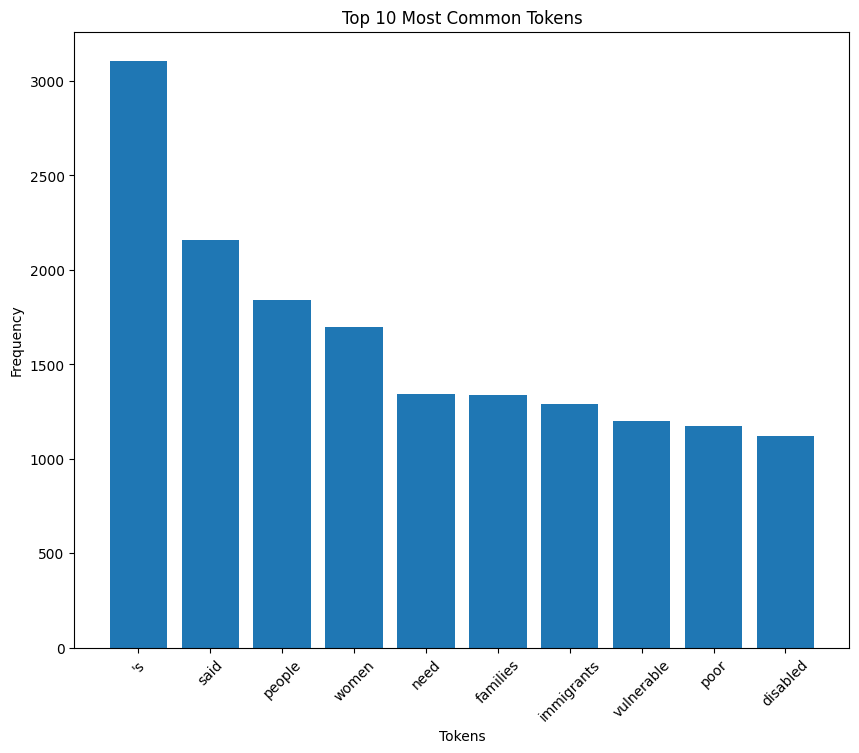

In [39]:
#Making the tokens in the filtered corpus not case sensitive and does not include punctuations
print(string.punctuation)
new_corpus = []
for i in range(len(filtered_corpus)):
  if str(filtered_corpus[i]).lower() not in stop_words and str(filtered_corpus[i]) not in string.punctuation and str(filtered_corpus[i]) not in ['"""','""','."', '']:
      new_corpus.append(str(filtered_corpus[i]).lower())


token_counts = Counter(new_corpus)
most_common_tokens = token_counts.most_common(10)

tokens, counts = zip(*most_common_tokens)

plt.figure(figsize=(10, 8))
plt.bar(tokens, counts)
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Tokens')
plt.xticks(rotation=45)
plt.show()

##Analysing n-grams

In [40]:
def n_grams(corpus, size, top_counts):
    n_grams_options = ngrams(corpus, size)
    n_gram_counts = Counter(n_grams_options)
    top_n_grams = n_gram_counts.most_common(top_counts)

    print(f"Top {10} {2}-grams:")
    for n_gram, count in top_n_grams:
        print(f"{n_gram}: {count}")
n_grams(corpus = new_corpus, size = 2, top_counts = 10)
n_grams(corpus = new_corpus, size = 3, top_counts = 10)

Top 10 2-grams:
('poor', 'families'): 909
('illegal', 'immigrants'): 307
('women', "'s"): 196
('per', 'cent'): 165
('united', 'states'): 161
('homeless', 'people'): 136
('last', 'year'): 127
('disabled', 'people'): 119
('people', 'need'): 112
('sri', 'lanka'): 107
Top 10 2-grams:
('children', 'poor', 'families'): 83
('president', 'donald', 'trump'): 53
('students', 'poor', 'families'): 35
('many', 'poor', 'families'): 33
('come', 'poor', 'families'): 31
('donald', 'trump', "'s"): 29
('un', 'refugee', 'agency'): 27
('need', 'humanitarian', 'assistance'): 19
('<h>', 'email', 'friend'): 18
('dar', 'es', 'salaam'): 17


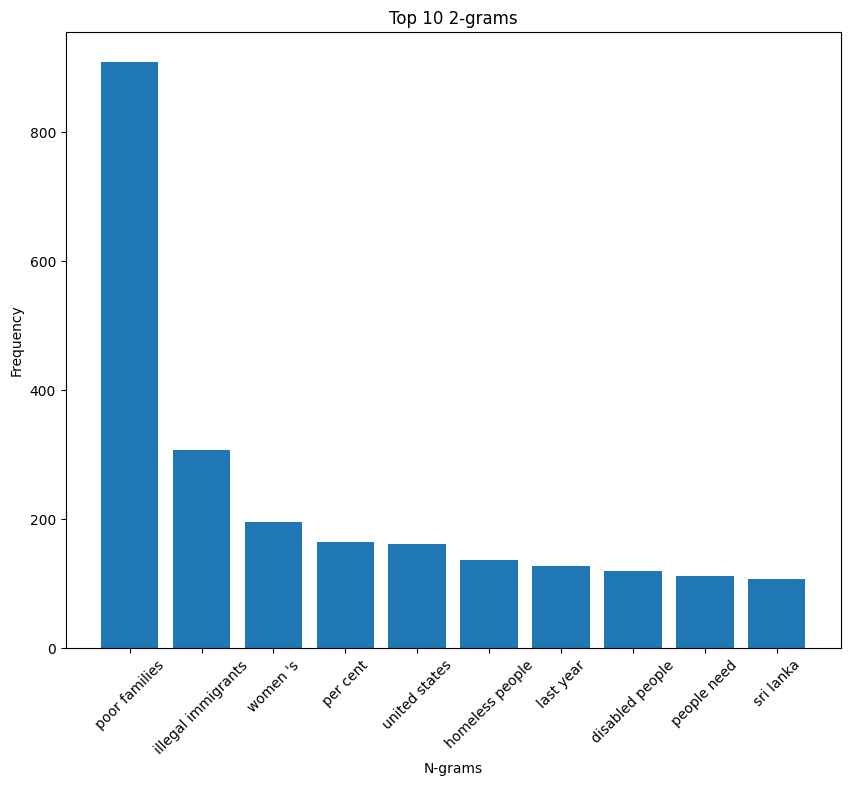

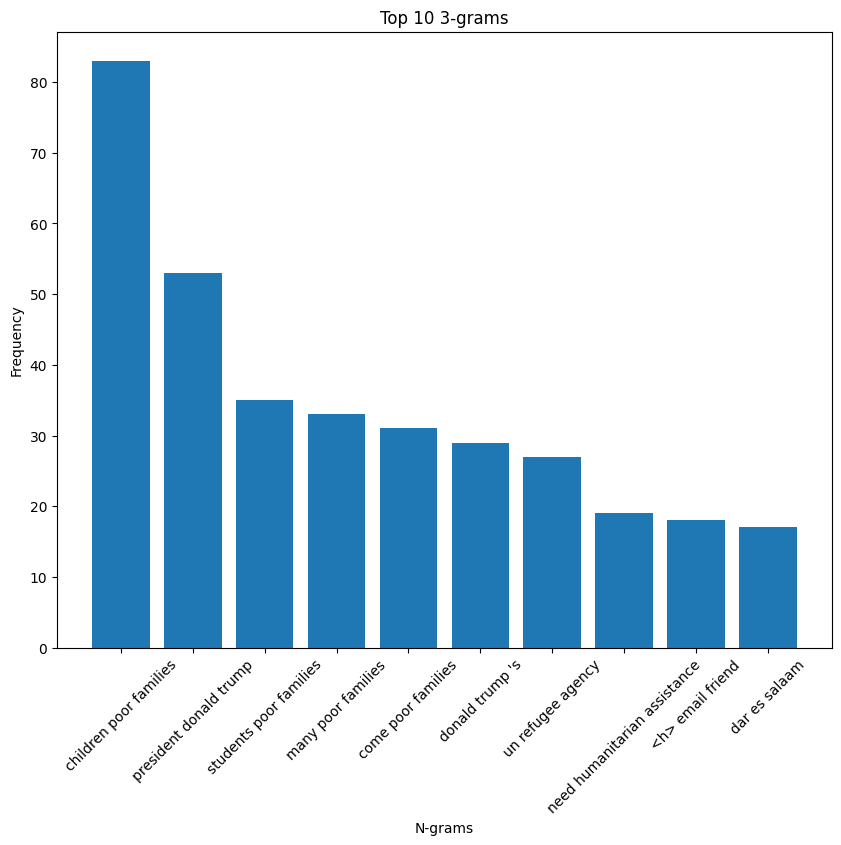

In [41]:
def plot_top_n_grams(corpus, size, top_counts):
    n_grams_options = ngrams(corpus, size)
    n_gram_counts = Counter(n_grams_options)
    top_n_grams = n_gram_counts.most_common(top_counts)

    n_gram_labels = [' '.join(n_gram) for n_gram, _ in top_n_grams]
    counts = [count for _, count in top_n_grams]
    plt.figure(figsize=(10, 8))
    plt.bar(n_gram_labels, counts)
    plt.xlabel('N-grams')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_counts} {size}-grams')
    plt.xticks(rotation=45)
    plt.show()

#plotting 2-grams
plot_top_n_grams(corpus = new_corpus, size = 2, top_counts = 10)

#plotting 3-grams
plot_top_n_grams(corpus = new_corpus, size = 3, top_counts = 10)



##Data Augumentation

In [42]:
# Code snippet from: https://maelfabien.github.io/machinelearning/NLP_8/#synonym-replacement-sr

import random
def get_synonyms(word):
  synonyms = set()

  for syn in wordnet.synsets(word):
    for l in syn.lemmas():
      synonym = l.name().replace("_", " ").replace("-", " ").lower()
      synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
      synonyms.add(synonym)

  if word in synonyms:
    synonyms.remove(word)

  return list(synonyms)


def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

In [43]:
import re

def clean_text(line):
    # Replace special characters with spaces or nothing
    line = line.replace("’", "").replace("'", "").replace("-", " ").replace("\t", " ").replace("\n", " ")
    line = line.lower()  # Convert to lowercase

    # Keep only alphabets and spaces
    clean_line = ''.join(char if char.isalpha() or char == ' ' else ' ' for char in line)

    # Remove extra spaces
    clean_line = re.sub(r'\s+', ' ', clean_line).strip()

    return clean_line

In [44]:
def augment_sentence(sentence, num_aug, synonym_alpha=0.1, insert_alpha=0.1, swap_alpha=0.1, delete_prob=0.1):
    sentence = clean_text(sentence)
    words = sentence.split()
    words = [word for word in words if word]  # Remove empty strings
    num_words = len(words)

    augmented_sentences = []

    # Synonym Replacement
    if synonym_alpha > 0:
        num_syn_replacements = max(1, int(synonym_alpha * num_words))
        for _ in range(num_aug):
            augmented_words = synonym_replacement(words, num_syn_replacements)
            augmented_sentences.append(' '.join(augmented_words))

    # Clean and shuffle augmented sentences
    augmented_sentences = [clean_text(sentence) for sentence in augmented_sentences]
    random.shuffle(augmented_sentences)

    # Control the number of augmented sentences
    if num_aug >= 1:
        augmented_sentences = augmented_sentences[:num_aug]
    else:
        keep_prob = num_aug / len(augmented_sentences)
        augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

    augmented_sentences.append(sentence)

    return augmented_sentences

def augment_data(data_df, num_aug):
    augmented_rows = []

    for index, sample in data_df.iterrows():
        text = sample['text']
        augmented_sentences = augment_sentence(text, num_aug)
        for sentence in augmented_sentences:
            id = sample['par_id']
            label = sample['label']
            augmented_rows.append({'par_id': id, 'text': sentence, 'label': label})

    augmented_df = pd.concat([pd.DataFrame(augmented_rows)], ignore_index=True)
    return augmented_df


In [45]:
def augment_minority_class_samples(samples, num_augmentations):
    augmented_samples = augment_data(samples, num_aug=num_augmentations)
    return augmented_samples

def augment_majority_class_samples(samples, num_augmentations):
    augmented_samples = augment_data(samples, num_aug=num_augmentations)
    return augmented_samples

num_augmentations = 4

# Augment samples of the minority class
minority_class_samples = train_set[train_set.label == 1]
print(len(minority_class_samples))
augmented_minority_samples = augment_minority_class_samples(minority_class_samples, num_augmentations)
num_augmented_minority_samples = len(augmented_minority_samples)

# Augment samples of the majority class
majority_class_samples = train_set[train_set.label == 0]
print(len(majority_class_samples))
augmented_majority_samples = augment_majority_class_samples(majority_class_samples, num_augmentations)

# Combine augmented samples of minority and majority classes
augmented_majority_samples = augmented_majority_samples[:int(num_augmented_minority_samples * (num_augmentations - 1))]
training_set_augmented = pd.concat([augmented_minority_samples, augmented_majority_samples])


794
7581


In [47]:
print(train_set["text"])

0       scheme saw estimate 150000 chilre poor family ...
1            urba s homeless commuities recociliatio luch
2       ext immeiate problem croppe assist ufortuate c...
3       far importat implicatios ecoomy go ollar last ...
4       stregthe chilsesitive social protectio system ...
                              ...                        
8370    rescue team search survivor rubble builig foll...
8371    lauch happy birthay took place last saturay sa...
8372    urest left least 20000 people ea igeria mae 26...
8373    see perspective may jouralist strictest sese s...
8374    yet oe occasio wet scee triple murer woma took...
Name: text, Length: 8375, dtype: object


In [48]:
#data augumentation technique 1 - Synonym Replacement
wordnet_aug = WordNetAugmenter()

def synonym_replacement(text):
   augumented_text_with_synonyms =  wordnet_aug.augment(text)
   return augumented_text_with_synonyms


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [49]:
#data augumentation technique 2 - Random Insertion synonym
def random_insertion(sentence, n):
    words = nltk.word_tokenize(sentence)
    new_sentence = words.copy()
    for _ in range(n):
        # Find words that have synonyms
        synonyms = []
        for word in words:
            for syn in wordnet.synsets(word):
                for lemma in syn.lemmas():
                    if lemma.name() != word:
                        synonyms.append(lemma.name())

        if synonyms:
            # Choose a random synonym
            synonym = choice(synonyms)
            # Choose a random position to insert
            position = randint(0, len(new_sentence))
            new_sentence.insert(position, synonym)

    return ' '.join(new_sentence)


In [50]:
#data augumentation technique 3 - random deletion

def random_deletion(text, p=0.2):
    if len(text) == 1:
        return text
    text = text.split(" ")
    remaining = [word for word in text if randint(0, 99) > p * 100]
    new_text =  ' '.join(remaining)
    return new_text if remaining else [choice(text)]

# Baseline models

In [51]:
baselines = [
    Pipeline([('Bag of Words', CountVectorizer()),
              ('Naive Bayes', MultinomialNB())]),
    Pipeline([('Bag of Words', CountVectorizer()),
              ('Logistic Regression', LogisticRegression(max_iter=2000))])
]

In [52]:
def train_model(model, train_set, test_set, n_splits=5):
  actual = list()
  predictions = list()
  fold = KFold(n_splits=n_splits, shuffle=True)
  data = pd.concat([train_set[['text', 'label']],
                    test_set[['text', 'label']]])

  print(len(data))
  for train_indices, test_indices in fold.split(data):
    act, pred = get_predictions(model, data.iloc[train_indices], data.iloc[test_indices])

    actual += act
    predictions += pred

  return actual, predictions

def get_predictions(model, train_set, test_set):
  model.fit(train_set['text'], train_set['label'])
  predictions = model.predict(test_set['text'])
  return test_set['label'].values.tolist(), predictions.tolist()

def run_models(models, train_set, test_set, k_fold=False):
  results = []

  for model in models:
    if k_fold:
      actual, prediction = train_model(model, train_set, test_set)
    else:
      actual, prediction = get_predictions(model, train_set, test_set)

    results.append(f'{list(map(lambda x : x[0], model.steps))}: {f1_score(actual, prediction)}')

  return results

In [53]:
train_set_shuffled = shuffle(train_set[['text', 'label']])
test_set_shuffled = shuffle(dev_set[['text', 'label']])

print(f'F1 score on each baseline:\n{run_models(baselines, train_set_shuffled, test_set_shuffled)}')
print(f'F1 scores for each baseline with cross validation\n: {run_models(baselines, train_set_shuffled, test_set_shuffled, k_fold=True)}')

F1 score on each baseline:
["['Bag of Words', 'Naive Bayes']: 0.23270440251572325", "['Bag of Words', 'Logistic Regression']: 0.05405405405405405"]
10469
10469
F1 scores for each baseline with cross validation
: ["['Bag of Words', 'Naive Bayes']: 0.05747126436781609", "['Bag of Words', 'Logistic Regression']: 0.29403409090909094"]


# Transformers

In [54]:
# train_set_aug1 = train_set
# print(synonym_replacement(['i', 'like',  'cocks'], 3))
# train_set_aug1['text'] = train_set_aug1['text'].apply(lambda x: synonym_replacement(x, len(x.split(' '))))

# train_set_shuffled = shuffle(train_set_aug1[['text', 'label']])
# test_set_shuffled = shuffle(dev_set[['text', 'label']])

In [55]:
def evaluate_model(model_type, model_name, train_set, valid_set, weights = [1.0, 1.0]):
  model_args = ClassificationArgs(num_train_epochs=3,
                                  no_save=True,
                                  no_cache=True,
                                  overwrite_output_dir=True)
  print(model_args)
  if weights[0] == weights[1] == 1:
    model = ClassificationModel(model_type,
                                model_name,
                                args=model_args,
                                num_labels=2,
                                use_cuda=cuda_available)
  else:
    model = ClassificationModel(model_type,
                                model_name,
                                args=model_args,
                                num_labels=2,
                                weight=weights,
                                use_cuda=cuda_available)

  # train model
  _ = model.train_model(train_set[['text', 'label']])

  # evaluate model
  return model.eval_model(
      valid_set[['text', 'label']],
      f1=f1_score,
      acc=accuracy_score,
  )

## Class weights

In [107]:
weight_class_false = training_set_aug.shape[0] / (2 * training_set_aug[training_set_aug['label'] == 0].shape[0])
weight_class_true =  training_set_aug.shape[0] / (2 * training_set_aug[training_set_aug['label'] == 1].shape[0])

weights = [weight_class_false, weight_class_true]
print(weights)

[0.6666666666666666, 2.0]


## BERT models

In [60]:
results = []
models = [
          ('roberta', 'roberta-base'),
          ('albert', 'albert-base-v2'),
          ('distilbert', 'distilbert-base-uncased'),
          ('distilbert', 'distilbert-base-cased-distilled-squad'),
          ('deberta', 'microsoft/deberta-base'),
          ('bigbird', 'google/bigbird-roberta-base')
        ]


for (model_type, model_name) in models:
  result, model_outputs, wrong_predictions = evaluate_model(model_type,
                                                            model_name,
                                                            training_set_aug,
                                                            dev_set,
                                                            # weights
                                                            )
  results.append({model_name: result})
  print(model_name)
  print(result)
  print("\n\n")

print(results)

ClassificationArgs(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=True, adafactor_scale_parameter=True, adafactor_warmup_init=True, adam_betas=(0.9, 0.999), adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=100, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=2000, evaluate_during_training_verbose=False, evaluate_each_epoch=True, fp16=True, gradient_accumulation_steps=1, learning_rate=4e-05, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_see

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

roberta-base
{'mcc': 0.5232128627485718, 'accuracy': 0.9283667621776505, 'f1_score': 0.5481927710843374, 'tp': 91, 'tn': 1853, 'fp': 42, 'fn': 108, 'auroc': 0.8793174314845997, 'auprc': 0.5725353389209012, 'f1': 0.5481927710843374, 'acc': 0.9283667621776505, 'eval_loss': 0.4891001317065231}



ClassificationArgs(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=True, adafactor_scale_parameter=True, adafactor_warmup_init=True, adam_betas=(0.9, 0.999), adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=100, evaluate_durin

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

albert-base-v2
{'mcc': 0.3631868843541143, 'accuracy': 0.8887297039159503, 'f1_score': 0.4246913580246914, 'tp': 86, 'tn': 1775, 'fp': 120, 'fn': 113, 'auroc': 0.8456703040267299, 'auprc': 0.4132234405402431, 'f1': 0.4246913580246914, 'acc': 0.8887297039159503, 'eval_loss': 0.3507169708609581}



ClassificationArgs(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=True, adafactor_scale_parameter=True, adafactor_warmup_init=True, adam_betas=(0.9, 0.999), adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=100, evaluate_du

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

distilbert-base-uncased
{'mcc': 0.42934304343279567, 'accuracy': 0.9159503342884432, 'f1_score': 0.460122699386503, 'tp': 75, 'tn': 1843, 'fp': 52, 'fn': 124, 'auroc': 0.8631097439705122, 'auprc': 0.5069238279886835, 'f1': 0.460122699386503, 'acc': 0.9159503342884432, 'eval_loss': 0.6981125218319774}



ClassificationArgs(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=True, adafactor_scale_parameter=True, adafactor_warmup_init=True, adam_betas=(0.9, 0.999), adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=100, eval

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased-distilled-squad and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

distilbert-base-cased-distilled-squad
{'mcc': 0.3739546590329861, 'accuracy': 0.9111747851002865, 'f1_score': 0.4, 'tp': 62, 'tn': 1846, 'fp': 49, 'fn': 137, 'auroc': 0.8451691173545829, 'auprc': 0.48585082531619334, 'f1': 0.4, 'acc': 0.9111747851002865, 'eval_loss': 0.8202104380404871}



ClassificationArgs(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=True, adafactor_scale_parameter=True, adafactor_warmup_init=True, adam_betas=(0.9, 0.999), adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=100, evaluate_during_tr

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

microsoft/deberta-base
{'mcc': 0.5150000945107743, 'accuracy': 0.9040114613180515, 'f1_score': 0.5620915032679739, 'tp': 129, 'tn': 1764, 'fp': 131, 'fn': 70, 'auroc': 0.867971785046605, 'auprc': 0.5298854802353912, 'f1': 0.5620915032679739, 'acc': 0.9040114613180515, 'eval_loss': 0.6095816776866004}



ClassificationArgs(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=True, adafactor_scale_parameter=True, adafactor_warmup_init=True, adam_betas=(0.9, 0.999), adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=100, eval

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Attention type 'block_sparse' is not possible if sequence_length: 128 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Running Epoch 2 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

google/bigbird-roberta-base
{'mcc': 0.4406287332442902, 'accuracy': 0.8925501432664756, 'f1_score': 0.49664429530201337, 'tp': 111, 'tn': 1758, 'fp': 137, 'fn': 88, 'auroc': 0.854235557735909, 'auprc': 0.4991931727125752, 'f1': 0.49664429530201337, 'acc': 0.8925501432664756, 'eval_loss': 0.6083758445013137}



[{'roberta-base': {'mcc': 0.5232128627485718, 'accuracy': 0.9283667621776505, 'f1_score': 0.5481927710843374, 'tp': 91, 'tn': 1853, 'fp': 42, 'fn': 108, 'auroc': 0.8793174314845997, 'auprc': 0.5725353389209012, 'f1': 0.5481927710843374, 'acc': 0.9283667621776505, 'eval_loss': 0.4891001317065231}}, {'albert-base-v2': {'mcc': 0.3631868843541143, 'accuracy': 0.8887297039159503, 'f1_score': 0.4246913580246914, 'tp': 86, 'tn': 1775, 'fp': 120, 'fn': 113, 'auroc': 0.8456703040267299, 'auprc': 0.4132234405402431, 'f1': 0.4246913580246914, 'acc': 0.8887297039159503, 'eval_loss': 0.3507169708609581}}, {'distilbert-base-uncased': {'mcc': 0.42934304343279567, 'accuracy': 0.9159503342884432,

In [61]:
for idx, el in enumerate(results):
  mod = list(results[idx].keys())[0]
  print(mod, results[idx][mod]['f1_score'])

print(results)

roberta-base 0.5481927710843374
albert-base-v2 0.4246913580246914
distilbert-base-uncased 0.460122699386503
distilbert-base-cased-distilled-squad 0.4
microsoft/deberta-base 0.5620915032679739
google/bigbird-roberta-base 0.49664429530201337
[{'roberta-base': {'mcc': 0.5232128627485718, 'accuracy': 0.9283667621776505, 'f1_score': 0.5481927710843374, 'tp': 91, 'tn': 1853, 'fp': 42, 'fn': 108, 'auroc': 0.8793174314845997, 'auprc': 0.5725353389209012, 'f1': 0.5481927710843374, 'acc': 0.9283667621776505, 'eval_loss': 0.4891001317065231}}, {'albert-base-v2': {'mcc': 0.3631868843541143, 'accuracy': 0.8887297039159503, 'f1_score': 0.4246913580246914, 'tp': 86, 'tn': 1775, 'fp': 120, 'fn': 113, 'auroc': 0.8456703040267299, 'auprc': 0.4132234405402431, 'f1': 0.4246913580246914, 'acc': 0.8887297039159503, 'eval_loss': 0.3507169708609581}}, {'distilbert-base-uncased': {'mcc': 0.42934304343279567, 'accuracy': 0.9159503342884432, 'f1_score': 0.460122699386503, 'tp': 75, 'tn': 1843, 'fp': 52, 'fn': 12

## Hyperparameter tuning

In [74]:
number_epochs = [1, 2, 3, 4, 5, 6]
learning_rates = [1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5]
batch_sizes = [8]
results = []
hyperparameters = []
model_type = 'roberta'
model_name = 'roberta-base'

for ep in number_epochs:
  for lr in learning_rates:
    for bs in batch_sizes:
      model_args = ClassificationArgs(num_train_epochs=ep,
                                      learning_rate=lr,
                                      train_batch_size=bs,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True)

      model = ClassificationModel(model_type,
                                  model_name,
                                  args=model_args,
                                  num_labels=2,
                                  use_cuda=cuda_available)

      _ = model.train_model(training_set_aug[['text', 'label']])

      metrics, predictions, _ = model.eval_model(
          dev_set[['text', 'label']],
          f1=f1_score,
          accuracy=accuracy_score
      )

      hyperparameters.append({'learning_rate': lr, 'batch_size': bs, 'num_epochs': ep})
      results.append(metrics)

      print(results)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 6 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 6 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 6 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 6 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 6 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 6 of 6:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}, {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}, {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}, {'mcc': 0.5078035687186515, 'accuracy': 0.9207258834765998, 'f1_score': 0.5489130434782609, 'tp': 101, 'tn': 1827, 'fp': 68, 'fn': 98, 'auroc': 0.904694978852044, 'auprc': 0.5682710235014062, 'f1': 0.5489130434782609, 'eval_loss': 0.309

In [84]:
b

{'learning_rate': 1e-05, 'batch_size': 8, 'num_epochs': 1} {'mcc': 0.5341306755018287, 'accuracy': 0.9135625596943648, 'f1_score': 0.5800464037122971, 'tp': 125, 'tn': 1788, 'fp': 107, 'fn': 74, 'auroc': 0.9196669362644356, 'auprc': 0.6136172520907366, 'f1': 0.5800464037122971, 'eval_loss': 0.26984849926971255}
{'learning_rate': 2e-05, 'batch_size': 8, 'num_epochs': 1} {'mcc': 0.5200419661029357, 'accuracy': 0.9111747851002865, 'f1_score': 0.5674418604651164, 'tp': 122, 'tn': 1786, 'fp': 109, 'fn': 77, 'auroc': 0.9164132005674812, 'auprc': 0.6135919464084882, 'f1': 0.5674418604651164, 'eval_loss': 0.2746592886036351}
{'learning_rate': 3e-05, 'batch_size': 8, 'num_epochs': 1} {'mcc': 0.5282524879107731, 'accuracy': 0.9164278892072588, 'f1_score': 0.5742092457420925, 'tp': 118, 'tn': 1801, 'fp': 94, 'fn': 81, 'auroc': 0.9142400657641772, 'auprc': 0.6221892939819119, 'f1': 0.5742092457420925, 'eval_loss': 0.32206370238037335}
{'learning_rate': 4e-05, 'batch_size': 8, 'num_epochs': 1} {'mc

In [86]:
results_df = pd.DataFrame({'num_epochs': eps, 'learning_rate': lrs, 'batch_size': bs, 'f1_score': f1_score})


results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
print(results_df)

    num_epochs  learning_rate  batch_size  f1_score
0            1        0.00001           8  0.580046
1            1        0.00002           8  0.567442
2            1        0.00003           8  0.574209
3            1        0.00004           8  0.548913
4            1        0.00005           8  0.510549
5            1        0.00006           8  0.498801
6            2        0.00001           8  0.581560
7            2        0.00002           8  0.555556
8            2        0.00003           8  0.578947
9            2        0.00004           8  0.525140
10           2        0.00005           8  0.551546
11           2        0.00006           8  0.508393
12           3        0.00001           8  0.586118
13           3        0.00002           8  0.568182
14           3        0.00003           8  0.547059
15           3        0.00004           8  0.515789
16           3        0.00005           8  0.516746
17           3        0.00006           8  0.000000
18          

In [98]:
number_epochs = [1, 2, 3]
learning_rates = [1e-5]
batch_sizes = [4]
results = []
hyperparameters = []
model_type = 'roberta'
model_name = 'roberta-base'

for ep in number_epochs:
  for lr in learning_rates:
    for bs in batch_sizes:
      model_args = ClassificationArgs(num_train_epochs=ep,
                                      learning_rate=lr,
                                      train_batch_size=bs,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True)

      model = ClassificationModel(model_type,
                                  model_name,
                                  args=model_args,
                                  num_labels=2,
                                  use_cuda=cuda_available)

      _ = model.train_model(training_set_aug[['text', 'label']])

      metrics, predictions, _ = model.eval_model(
          dev_set[['text', 'label']]
      )

      hyperparameters.append({'learning_rate': lr, 'batch_size': bs, 'num_epochs': ep})
      results.append(metrics)

      print(results)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/3970 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5212637769876222, 'accuracy': 0.9078319006685769, 'f1_score': 0.5682326621923938, 'tp': 127, 'tn': 1774, 'fp': 121, 'fn': 72, 'auroc': 0.9156030813699102, 'auprc': 0.5811270103998979, 'eval_loss': 0.3717348783143929}]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/3970 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/3970 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5212637769876222, 'accuracy': 0.9078319006685769, 'f1_score': 0.5682326621923938, 'tp': 127, 'tn': 1774, 'fp': 121, 'fn': 72, 'auroc': 0.9156030813699102, 'auprc': 0.5811270103998979, 'eval_loss': 0.3717348783143929}, {'mcc': 0.5551489283067511, 'accuracy': 0.9264565425023877, 'f1_score': 0.5947368421052631, 'tp': 113, 'tn': 1827, 'fp': 68, 'fn': 86, 'auroc': 0.8997958128372734, 'auprc': 0.6097079147326621, 'eval_loss': 0.5257725510787817}]


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/3970 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/3970 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/3970 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

[{'mcc': 0.5212637769876222, 'accuracy': 0.9078319006685769, 'f1_score': 0.5682326621923938, 'tp': 127, 'tn': 1774, 'fp': 121, 'fn': 72, 'auroc': 0.9156030813699102, 'auprc': 0.5811270103998979, 'eval_loss': 0.3717348783143929}, {'mcc': 0.5551489283067511, 'accuracy': 0.9264565425023877, 'f1_score': 0.5947368421052631, 'tp': 113, 'tn': 1827, 'fp': 68, 'fn': 86, 'auroc': 0.8997958128372734, 'auprc': 0.6097079147326621, 'eval_loss': 0.5257725510787817}, {'mcc': 0.5212631125819441, 'accuracy': 0.9192932187201528, 'f1_score': 0.5655526992287918, 'tp': 110, 'tn': 1815, 'fp': 80, 'fn': 89, 'auroc': 0.898615770143594, 'auprc': 0.5975102737400412, 'eval_loss': 0.708829487718287}]


In [97]:
print(training_set_aug)

      par_id                                               text  label
0       4341  the scheme saw an estimated children from piti...      1
1       4341  the scheme saw an estimated children from poor...      1
2       4341  the scheme saw an estimated youngster from poo...      1
3       4341  the scheme saw an estimated nipper from poor f...      1
4       4341  the scheme saw an estimated children from poor...      1
...      ...                                                ...    ...
11905   6590  talking to the daily star over the phone a few...      0
11906   6591  cameroon has deliver nigerian refugees in the ...      0
11907   6591  cameroon has deported nigerian refugees in the...      0
11908   6592  north and to the south korea have fit in princ...      0
11909   6592  north and south korea have agreed in principle...      0

[15880 rows x 3 columns]


In [99]:
f1_score = []
lrs = []
bs = []
eps = []
for idx, _ in enumerate(results):
  f1_score.append(results[idx]['f1_score'])
  lrs.append(hyperparameters[idx]['learning_rate'])
  bs.append(hyperparameters[idx]['batch_size'])
  eps.append(hyperparameters[idx]['num_epochs'])

  print(hyperparameters[idx], results[idx])
print(f1_score)

{'learning_rate': 1e-05, 'batch_size': 4, 'num_epochs': 1} {'mcc': 0.5212637769876222, 'accuracy': 0.9078319006685769, 'f1_score': 0.5682326621923938, 'tp': 127, 'tn': 1774, 'fp': 121, 'fn': 72, 'auroc': 0.9156030813699102, 'auprc': 0.5811270103998979, 'eval_loss': 0.3717348783143929}
{'learning_rate': 1e-05, 'batch_size': 4, 'num_epochs': 2} {'mcc': 0.5551489283067511, 'accuracy': 0.9264565425023877, 'f1_score': 0.5947368421052631, 'tp': 113, 'tn': 1827, 'fp': 68, 'fn': 86, 'auroc': 0.8997958128372734, 'auprc': 0.6097079147326621, 'eval_loss': 0.5257725510787817}
{'learning_rate': 1e-05, 'batch_size': 4, 'num_epochs': 3} {'mcc': 0.5212631125819441, 'accuracy': 0.9192932187201528, 'f1_score': 0.5655526992287918, 'tp': 110, 'tn': 1815, 'fp': 80, 'fn': 89, 'auroc': 0.898615770143594, 'auprc': 0.5975102737400412, 'eval_loss': 0.708829487718287}
[0.5682326621923938, 0.5947368421052631, 0.5655526992287918]


In [100]:
results_df2 = pd.DataFrame({'num_epochs': eps, 'learning_rate': lrs, 'batch_size': bs, 'f1_score': f1_score})


results_df2.to_csv('hyperparameter_tuning_results_batch.csv', index=False)
print(results_df2)

   num_epochs  learning_rate  batch_size  f1_score
0           1        0.00001           4  0.568233
1           2        0.00001           4  0.594737
2           3        0.00001           4  0.565553


## Grid Search Results and plots

In [103]:
concatenated_df = pd.concat([results_df, results_df2])
concatenated_df

num_epochs  learning_rate  batch_size  f1_score
0            1        0.00001           8  0.580046
1            1        0.00002           8  0.567442
2            1        0.00003           8  0.574209
3            1        0.00004           8  0.548913
4            1        0.00005           8  0.510549
5            1        0.00006           8  0.498801
6            2        0.00001           8  0.581560
7            2        0.00002           8  0.555556
8            2        0.00003           8  0.578947
9            2        0.00004           8  0.525140
10           2        0.00005           8  0.551546
11           2        0.00006           8  0.508393
12           3        0.00001           8  0.586118
13           3        0.00002           8  0.568182
14           3        0.00003           8  0.547059
15           3        0.00004           8  0.515789
16           3        0.00005           8  0.516746
17           3        0.00006           8  0.000000
18           4        0.00001           8  0.606061
19           4        0.00002           8  0.564103
20           4        0.00003           8  0.523256
21           4        0.00004           8  0.528090
22           4        0.00005           8  0.520231
23           4        0.00006           8  0.451327
24           5        0.00001           8  0.577540
25           5        0.00002           8  0.562319
26           5        0.00003           8  0.542773
27           5        0.00004           8  0.526316
28           5        0.00005           8  0.485149
29           5        0.00006           8  0.463551
30           6        0.00001           8  0.563380
31           6        0.00002           8  0.568116
32           6        0.00003           8  0.558659
33           6        0.00004           8  0.496933
34           6        0.00005           8  0.502857
35           6        0.00006           8  0.000000
0            1        0.00001           4  0.568233
1            2        0.00001           4  0.594737
2            3        0.00001           4  0.565553

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['num_epochs'].plot(kind='hist', bins=20, title='num_epochs')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['learning_rate'].plot(kind='hist', bins=20, title='learning_rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['batch_size'].plot(kind='hist', bins=20, title='batch_size')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='num_epochs', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='num_epochs', y='learning_rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='learning_rate', y='batch_size', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='batch_size', y='f1_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['num_epochs'].plot(kind='line', figsize=(8, 4), title='num_epochs')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['learning_rate'].plot(kind='line', figsize=(8, 4), title='learning_rate')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['batch_size'].plot(kind='line', figsize=(8, 4), title='batch_size')
plt.gca().spines[['top', 'right']].set_visible(False)

In [114]:
concatenated_df_round = concatenated_df.copy()
concatenated_df_round['f1_score'] = concatenated_df_round['f1_score'].round(2)
concatenated_df_round

num_epochs  learning_rate  batch_size  f1_score
0            1        0.00001           8      0.58
1            1        0.00002           8      0.57
2            1        0.00003           8      0.57
3            1        0.00004           8      0.55
4            1        0.00005           8      0.51
5            1        0.00006           8      0.50
6            2        0.00001           8      0.58
7            2        0.00002           8      0.56
8            2        0.00003           8      0.58
9            2        0.00004           8      0.53
10           2        0.00005           8      0.55
11           2        0.00006           8      0.51
12           3        0.00001           8      0.59
13           3        0.00002           8      0.57
14           3        0.00003           8      0.55
15           3        0.00004           8      0.52
16           3        0.00005           8      0.52
17           3        0.00006           8      0.00
18           4        0.00001           8      0.61
19           4        0.00002           8      0.56
20           4        0.00003           8      0.52
21           4        0.00004           8      0.53
22           4        0.00005           8      0.52
23           4        0.00006           8      0.45
24           5        0.00001           8      0.58
25           5        0.00002           8      0.56
26           5        0.00003           8      0.54
27           5        0.00004           8      0.53
28           5        0.00005           8      0.49
29           5        0.00006           8      0.46
30           6        0.00001           8      0.56
31           6        0.00002           8      0.57
32           6        0.00003           8      0.56
33           6        0.00004           8      0.50
34           6        0.00005           8      0.50
35           6        0.00006           8      0.00
0            1        0.00001           4      0.57
1            2        0.00001           4      0.59
2            3        0.00001           4      0.57

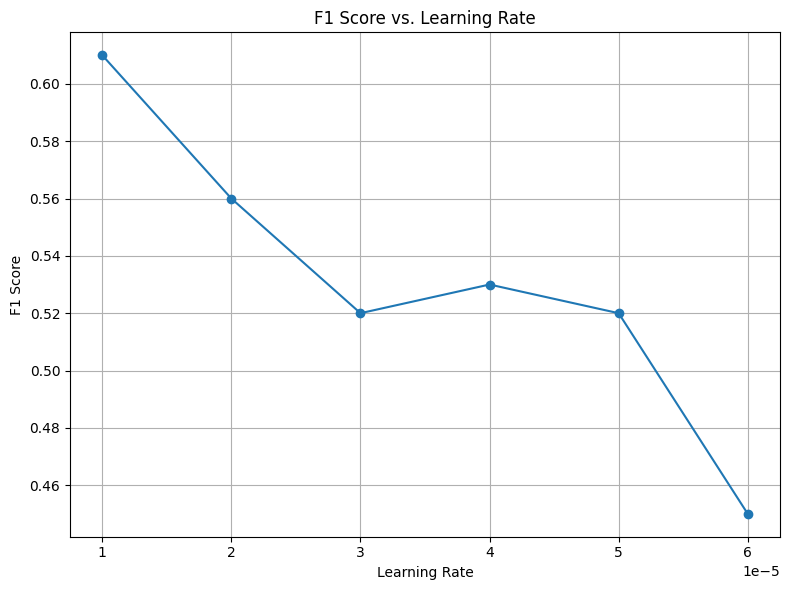

In [120]:
learning_rates = [1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5]
f1_scores = [0.61, 0.56, 0.52, 0.53, 0.52, 0.45]

plt.figure(figsize=(8, 6))
plt.plot(learning_rates, f1_scores, marker='o', linestyle='-')
plt.title('F1 Score vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('F1 Score')
# plt.xscale('log')
plt.grid(True)
plt.xticks(learning_rates)
plt.tight_layout()
plt.show()

# Best model


## Training

In [126]:
model_type = 'roberta'
model_name = 'roberta-base'
model_args = ClassificationArgs(num_train_epochs=4,
                                learning_rate=1e-5,
                                train_batch_size=8,
                                no_save=True,
                                no_cache=True,
                                overwrite_output_dir=True)


model = ClassificationModel(model_type,
                            model_name,
                            args=model_args,
                            num_labels=2,
                            use_cuda=cuda_available)

# train model
_ = model.train_model(training_set_aug[['text', 'label']])

# evaluate model
result, model_outputs, wrong_predictions =  model.eval_model(
    dev_set[['text', 'label']],
    # f1=f1_score,
    # acc=accuracy_score,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

Running Epoch 4 of 4:   0%|          | 0/1985 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/21 [00:00<?, ?it/s]

## Wrongly predicted score percentage

In [173]:
bad_predicted_ids = [el.guid for el in wrong_predictions]

df_wrong_preds = dev_set.iloc[bad_predicted_ids]

In [142]:
wrong_pred_freq_score = df_wrong_preds["score"].value_counts().to_dict()
print(wrong_pred_freq_score)

freq_score = dev_set["score"].value_counts().to_dict()
print(freq_score)
score_pred_percentage = {k: wrong_pred_freq_score[k] / freq_score[k] for k in freq_score.keys()}
print(score_pred_percentage)

{'0': 49, '3': 47, '1': 31, '4': 27, '2': 15}
{'0': 1704, '1': 191, '4': 92, '3': 89, '2': 18}
{'0': 0.028755868544600938, '1': 0.16230366492146597, '4': 0.29347826086956524, '3': 0.5280898876404494, '2': 0.8333333333333334}


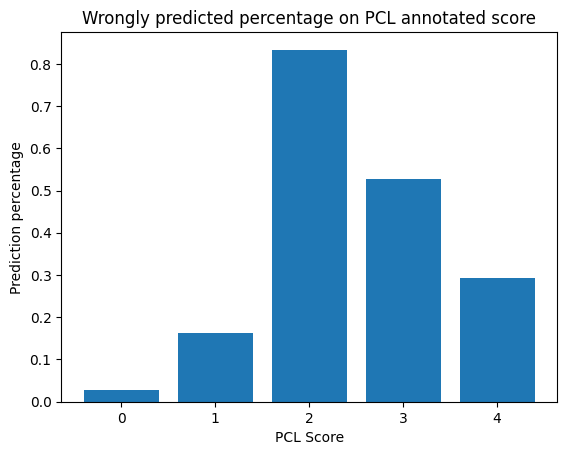

In [140]:
score_pred_percentage_sorted = dict(sorted(score_pred_percentage.items()))
keys = list(score_pred_percentage_sorted.keys())
values = list(score_pred_percentage_sorted.values())

# Plot
plt.bar(keys, values)
plt.xlabel('PCL Score')
plt.ylabel('Prediction percentage')
plt.title('Wrongly predicted percentage on PCL annotated score')
plt.show()

## Wrongly predicted sentence length percentage

In [144]:
wrong_pred_freq_len = df_wrong_preds["text"].apply(len).value_counts().to_dict()
print(wrong_pred_freq_len)

freq_len = dev_set["text"].apply(len).value_counts().to_dict()
print(freq_len)

len_pred_percentage = {k: wrong_pred_freq_len[k] / freq_len[k] if k in wrong_pred_freq_len.keys() else 0 for k in freq_len.keys()}
print(len_pred_percentage)

{196: 3, 355: 3, 376: 3, 177: 2, 358: 2, 92: 2, 363: 2, 274: 2, 357: 2, 95: 2, 296: 2, 413: 2, 338: 2, 288: 2, 190: 2, 285: 2, 197: 2, 427: 2, 243: 2, 394: 2, 74: 2, 229: 2, 161: 2, 183: 2, 187: 2, 209: 2, 201: 2, 267: 2, 316: 2, 298: 2, 136: 1, 100: 1, 158: 1, 184: 1, 341: 1, 185: 1, 53: 1, 140: 1, 217: 1, 98: 1, 103: 1, 455: 1, 75: 1, 469: 1, 396: 1, 175: 1, 97: 1, 239: 1, 121: 1, 301: 1, 399: 1, 351: 1, 299: 1, 145: 1, 111: 1, 195: 1, 47: 1, 180: 1, 120: 1, 236: 1, 198: 1, 476: 1, 134: 1, 101: 1, 59: 1, 148: 1, 214: 1, 40: 1, 321: 1, 378: 1, 204: 1, 178: 1, 211: 1, 529: 1, 395: 1, 206: 1, 182: 1, 728: 1, 130: 1, 493: 1, 218: 1, 152: 1, 625: 1, 404: 1, 429: 1, 224: 1, 94: 1, 295: 1, 171: 1, 275: 1, 205: 1, 254: 1, 194: 1, 444: 1, 340: 1, 263: 1, 207: 1, 400: 1, 343: 1, 188: 1, 328: 1, 219: 1, 426: 1, 208: 1, 908: 1, 369: 1, 123: 1, 138: 1, 389: 1, 634: 1, 734: 1, 116: 1, 768: 1, 80: 1, 143: 1, 526: 1, 146: 1, 506: 1, 387: 1, 155: 1, 530: 1, 441: 1, 556: 1, 297: 1, 364: 1, 637: 1, 401

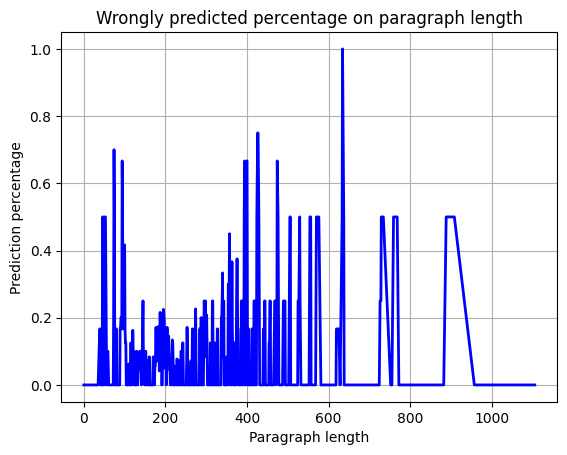

In [169]:
len_pred_percentage_sorted = dict(sorted(len_pred_percentage.items()))
keys = list(len_pred_percentage_sorted.keys())
values = list(len_pred_percentage_sorted.values())

# Apply moving average for smoothing
x = keys
y = values
window_size = 2
y_smooth = np.convolve(y, np.ones(window_size)/window_size, mode='valid')

# Plot
plt.plot(x[:len(y_smooth)], y_smooth, color='b', linewidth=2)
plt.xlabel('Paragraph length')
plt.ylabel('Prediction percentage')
plt.title('Wrongly predicted percentage on paragraph length')
plt.grid(True)
plt.show()


## Wrongly predicted data categories

In [176]:
wrong_pred_freq_category = df_wrong_preds["category"].value_counts().to_dict()
print(wrong_pred_freq_category)

freq_category = dev_set["category"].value_counts().to_dict()
print(freq_category)

category_pred_percentage = {k: wrong_pred_freq_category[k] / freq_category[k] if k in wrong_pred_freq_category.keys() else 0 for k in freq_category.keys()}
print(category_pred_percentage)

{'poor-families': 30, 'homeless': 29, 'in-need': 22, 'hopeless': 20, 'vulnerable': 19, 'refugee': 14, 'disabled': 14, 'women': 11, 'immigrant': 6, 'migrant': 4}
{'women': 233, 'in-need': 226, 'immigrant': 218, 'hopeless': 217, 'homeless': 212, 'vulnerable': 209, 'migrant': 207, 'disabled': 194, 'poor-families': 190, 'refugee': 188}
{'women': 0.04721030042918455, 'in-need': 0.09734513274336283, 'immigrant': 0.027522935779816515, 'hopeless': 0.09216589861751152, 'homeless': 0.13679245283018868, 'vulnerable': 0.09090909090909091, 'migrant': 0.01932367149758454, 'disabled': 0.07216494845360824, 'poor-families': 0.15789473684210525, 'refugee': 0.07446808510638298}


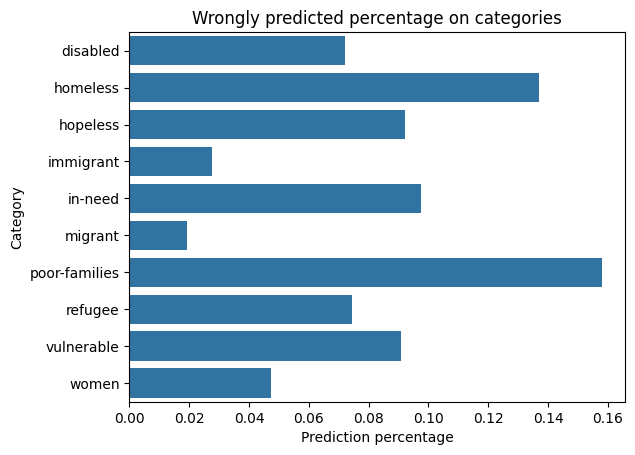

In [182]:
category_pred_percentage_sorted = dict(sorted(category_pred_percentage.items()))
keys = list(category_pred_percentage_sorted.keys())
values = list(category_pred_percentage_sorted.values())

# Plot
sns.barplot(x=values, y=keys)
plt.xlabel('Prediction percentage')
plt.ylabel('Category')
plt.title('Wrongly predicted percentage on categories')
plt.show()

## Run and save predictions

In [185]:
dev_predictions, raw_output_dev = model.predict(dev_set.text.tolist())
test_predictions, raw_output_test = model.predict(test_set.text.tolist())

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

In [189]:
def save_predictions(labels, output_path):
	with open(output_path,'w') as output_path:
	  output_path.write('\n'.join([str(k) for k in labels])+'\n')

In [191]:
save_predictions(dev_predictions.tolist(), 'dev.txt')
save_predictions(test_predictions.tolist(), 'test.txt')